In [137]:
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = '15'
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx import community
from tqdm import tqdm

import statsmodels.formula.api as smf

from helpers.readers import read_dataframe

# Load datasets and prepare merged dataframes

In [2]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
imdb_info = read_dataframe(name='imdb/movies', preprocess=True)
imdb_ratings = read_dataframe(name='imdb/ratings')
movieLens_movies = read_dataframe(name='movieLens/movies', preprocess=True)
movieLens_ratings = read_dataframe('movieLens/ratings')

imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


## Prepare the movies dataframe

In [3]:
mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')

In [4]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()

In [5]:
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

In [6]:
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

In [7]:
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

In [8]:
movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

In [9]:
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

In [10]:
# NOTE: Only adds ratings for 100 movies, not worth it

# movies = movies.merge(
#     right=movieLens_movies[['vote_average', 'vote_count', 'imdb_id']].rename(columns={'vote_average': 'rating_lens', 'vote_count': 'votes_lens', 'imdb_id': 'tconst'}),
#     on='tconst', how='left',
# )
# movies.rating_lens.replace(to_replace=0, value=pd.NA)

In [11]:
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

In [12]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [13]:
movies = movies.set_index('tconst')

## Prepare the directors dataframe

In [14]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28478 directors.


In [15]:
directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
directors = directors.set_index('nconst')

In [19]:
def dir_metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
tqdm.pandas(desc="Computing directors' score")
directors['score'] = directors.progress_apply(dir_metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

Computing directors' score: 100%|██████████| 28478/28478 [22:16<00:00, 21.31it/s]


## Q1 : How impactful is the team surrounding the director on the success of a movie ?

To answer to this question, we need additional information than what we already have in the `movies` & `directors` dataframe. Namely, the `imdb_people` and `imdb_principals` dataframe are of interest here.

- `imdb_people` contains birth/death years, primary professions and famous titles for ~12M people in the IMDb database

- `imdb_principals` contains the principal (max 10 per movie) people that have played in movies in the IMDb database (roughs out to ~58M rows)


They will thus be used to extract information about people that worked on the movies we selected. Their primary professions, the number of movies they played in, the potential nature of the roles they played in each movie (once actor, once writer, etc.)

We first retrieve 'reduce' these two dataframes to only contain information about the movies we decided to keep :

In [20]:
def matching_selected_people(imdb_people,imdb_principals,movies) : 

    imdb_people_exploded = imdb_people.copy()
    imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
    imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])


    merged_ipe = pd.merge(imdb_people_exploded,movies, how='inner', left_on='knownForTitles', right_on='tconst')
    unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')
    matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
    tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
    jobs_principal_people = pd.merge(tmp_principal_people,movies,on='tconst',how='inner')[['tconst','nconst','category','job']]

    return(matched_imdb_people,jobs_principal_people)

In [21]:
matched_imdb_people,jobs_principal_people = matching_selected_people(imdb_people,imdb_principals,movies)

We define a few functions that will help us retrieve interesting information, for our analysis, from these dataframes.

In [22]:
def get_all_known_roles(matched_principal,all_matched_people) : 
    """
    Adds additional movies that people present in the matched_principal dataframe passed as argument have played a certain role in.

    Args:
    matched_principal: The IMDb 'principal' dataframe matched for our selected movies. Contains
                       information about the 'principal' crew of each movie.

    all_matched_people: The IMDb 'people' dataframe matched for our selected movies. Contains
                        personal information about people in the film industry.

    Returns:
    enhanced_matched_principal: The all_matched_people dataframe passed as argument, with an additional column
                                containing any additional roles found in the matched_principal
                                dataframe. 
    """
    roles_collected = {}

    # Iterate over matched_principal to collect roles for each person
    for _, row in tqdm(matched_principal.iterrows()):
        nconst = row['nconst']
        tconst = row['tconst']
        
        if nconst not in roles_collected:
            roles_collected[nconst] = set()

        roles_collected[nconst].add(tconst)

    # Update enhanced_matched_principal with the collected roles
    enhanced_matched_principal = all_matched_people.copy()
    enhanced_matched_principal['all_known_roles'] = enhanced_matched_principal['nconst'].map(lambda x: ','.join(map(str, roles_collected.get(x,[]))))

    return enhanced_matched_principal

In [23]:
tqdm.pandas()

def add_directed_movies(directors_df, movies_df):
    """
    Returns a modified version of the directors_df dataframe, with a new column indicating all the movies directed in the movies_df dataframe, for each director.

    Args :
        directors_df : The dataframe containing the director's information
        movies_df : The dataframe containing the movies information

    Returns :
        directors_df : The original dataframe with the added column
    """
    directors_df['directed_movies'] = directors_df.progress_apply(lambda row: get_directed_movies(row, movies_df), axis=1)
    return directors_df

def get_directed_movies(director_row, movies_df):
    """
    Returns a list of the IMDb IDs of the movie directed by a certain director.

    Args :
        director_row : A row of the 'directors' dataframe, containing information about
        movies_df : The dataframe containing the movies information
    """
    curr_dir_id = director_row.name
    directed_movies = ','.join(movies_df[movies_df.directors.str.contains(curr_dir_id)].index)
    return directed_movies


In [24]:
mip_enhanced = get_all_known_roles(jobs_principal_people,matched_imdb_people)

0it [00:00, ?it/s]

618126it [00:30, 20589.85it/s]


In [25]:
enhanced_directors_df = add_directed_movies(directors, movies[['directors']])

100%|██████████| 28478/28478 [17:05<00:00, 27.76it/s]


In [23]:
test = enhanced_directors_df[enhanced_directors_df['avg-3'].notna()]

In [26]:
from collections import defaultdict
def counting_directors_collaborations(directors_df, matched_imdb_people):
    """
    Returns a dictionnary containing the number of collaborations between directors and different crew members, for the movies selected.

    Args :
    directors_df : A dataframe containing information about directors. it must contain at least the two following columns : 'nconst', the personal
                   IMDb ID of the director, and 'directed_movies' which they have directed
    
                   
    matched_imdb_people : A dataframe containing personal information about people that have worked on movies that we decided to retain. Must also contain
                          the 'nconst' and 'knownForTitles' columns.
    
    """
    # Create a mapping of titles to people : For each title, we create a mapping which basically adds, for each movie, all the people we know have played some role in the movie
    title_to_people = defaultdict(set)
    for _, person_row in tqdm(matched_imdb_people.iterrows(),total=len(matched_imdb_people)):
        person_id = person_row['nconst']
        known_for_titles = person_row['knownForTitles']
        all_known_roles = person_row['all_known_roles']

        known_for_titles = known_for_titles.split(',') if isinstance(known_for_titles,str) else []
        all_known_roles = all_known_roles.split(',') if isinstance(all_known_roles,str) else []

        unique_movies = set(filter(None, known_for_titles + all_known_roles))
        #print(person_id,unique_movies)
        for title in unique_movies:
                title_to_people[title].add(person_id)

    collaboration_counts = {}

    for _, row in tqdm(directors_df.iterrows(),total=len(directors_df)):
        director_ids = set(row.name.split(',')) if isinstance(row.name, str) else set()
        directed_titles = set(row['directed_movies'].split(',')) if isinstance(row['directed_movies'], str) else set()

        for director_id in director_ids:
            if director_id not in collaboration_counts:
                collaboration_counts[director_id] = {}

            for title in directed_titles:
                collaborators = title_to_people[title] - {director_id}  # Remove the director from collaborators
                for collaborator in collaborators:
                    if collaborator not in collaboration_counts[director_id]:
                        collaboration_counts[director_id][collaborator] = 1
                    else:
                        collaboration_counts[director_id][collaborator] += 1

    return collaboration_counts

In [27]:
collab_counts = counting_directors_collaborations(enhanced_directors_df,mip_enhanced)

100%|██████████| 28478/28478 [00:04<00:00, 6054.15it/s]


We have a dictionnary that keeps track of how much times each director has collaborated with other crew members in the IMDb.

---
## General overview of movie crews - Effect of movie crew size on director's success 

Let's see how many different people each director has worked with, without looking at if they collaborated a lot with the same people at first :

In [29]:
director_collaborators = []

for director, collaborations in collab_counts.items():
    num_collaborators = len(collaborations)
    director_collaborators.append({'Director': director, 'NumCollaborators': num_collaborators})

collab_counts_df = pd.DataFrame(director_collaborators)

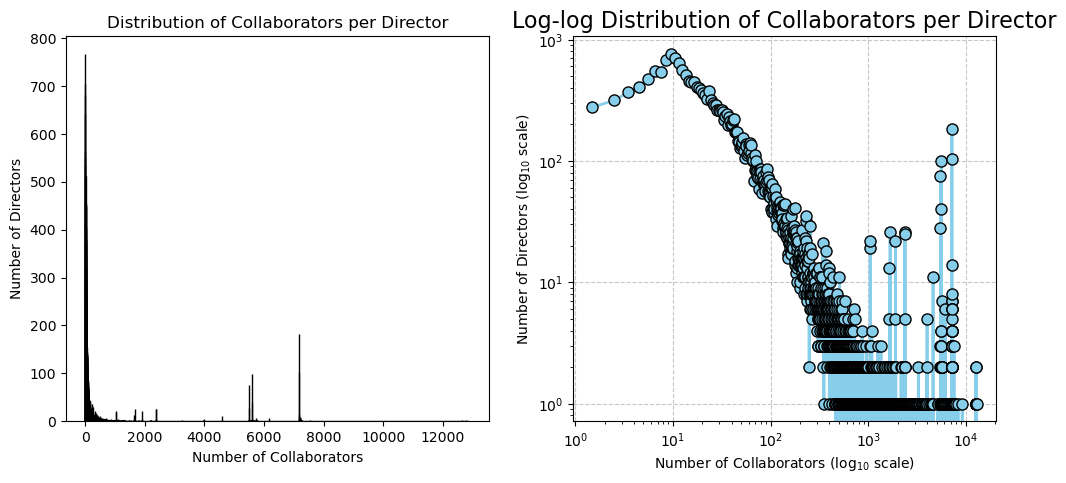

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2), edgecolor='black')
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Directors')
plt.title('Distribution of Collaborators per Director')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color='skyblue', markeredgecolor='black', linewidth=2, markersize=8)
plt.xlabel('Number of Collaborators (log$_{10}$ scale)')
plt.ylabel('Number of Directors (log$_{10}$ scale)')
plt.title('Log-log Distribution of Collaborators per Director', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.tight_layout()
plt.show();

We have a minority of directors that directed a huge number of films and thus had a huge number of collaborations throughout their career. Investigate the peaks for some directors on the right.

Let's see if this behaviour reproduces for the size of the movie crew :

In [32]:
def get_movie_crew_size(movies,matched_people) :
    """ 
    """
    crew = matched_people.copy()
    crew['knownForTitles'] = crew['knownForTitles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    crew['all_known_roles'] = crew['all_known_roles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())

    roles_union_df = crew[['knownForTitles', 'all_known_roles']].apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)
    roles_union_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_union_df})
    roles_union_df = roles_union_df.explode('roles_union')
    merged_df = pd.merge(movies, roles_union_df, left_index=True, right_on='roles_union')
    crew_sizes = pd.DataFrame(merged_df.groupby('roles_union')['nconst'].nunique())
    crew_sizes.rename(columns={'nconst': 'crew_size'},inplace=True)
    final_movies = pd.merge(movies,crew_sizes,left_index=True, right_index=True, how='left')

    return final_movies

In [33]:
movies_wcs = get_movie_crew_size(movies,mip_enhanced)
movies_wscs = movies_wcs[(movies_wcs['crew_size'] >= 10) & (movies_wcs['crew_size'] < 3000)]

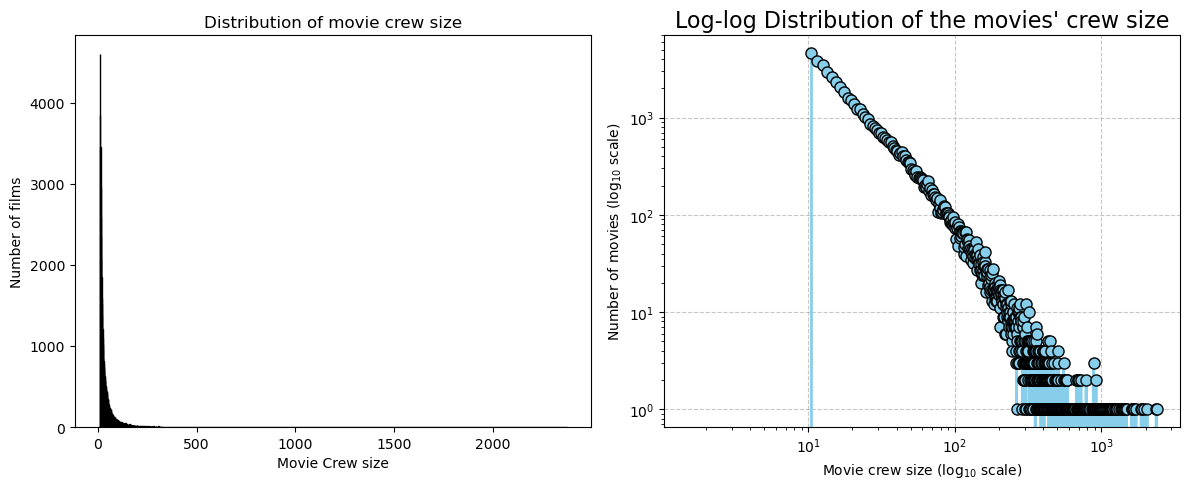

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(movies_wscs['crew_size'], bins=range(1, int(max(movies_wscs['crew_size'])) + 2), edgecolor='black')
plt.xlabel('Movie Crew size')
plt.ylabel('Number of films')
plt.title('Distribution of movie crew size')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(movies_wscs['crew_size'], bins=range(1, int(max(movies_wscs['crew_size'])) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color='skyblue', markeredgecolor='black', linewidth=2, markersize=8)
plt.xlabel('Movie crew size (log$_{10}$ scale)')
plt.ylabel('Number of movies (log$_{10}$ scale)')
plt.title('Log-log Distribution of the movies\' crew size', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The number of the movie's crew size follows a power law. Let's try to see how the directors surround themselves for their movies : do they always have a huge number of people around them ?

In [35]:
oui = enhanced_directors_df.copy()

oui['directed_movies'] = oui['directed_movies'].apply(lambda x: str(x).split(','))

# Explode the lists to separate rows for each movie ID
directors_exploded = oui.explode('directed_movies')

merged_df = pd.merge(directors_exploded, movies_wcs, how='left', left_on='directed_movies', right_index=True)

# Filter for rows where the director has directed at least 3 movies
filtered_directors = merged_df.groupby('nconst').filter(lambda x: x['directed_movies'].nunique() >= 3)

# Calculate the average crew size for each director
average_crew_size = pd.DataFrame(filtered_directors.groupby('nconst')['crew_size'].mean())

average_crew_size.rename(columns={'crew_size' : 'avg_crew_size'},inplace=True)

enhanced_directors_df = pd.merge(enhanced_directors_df,average_crew_size,how='left',left_index=True,right_index=True)

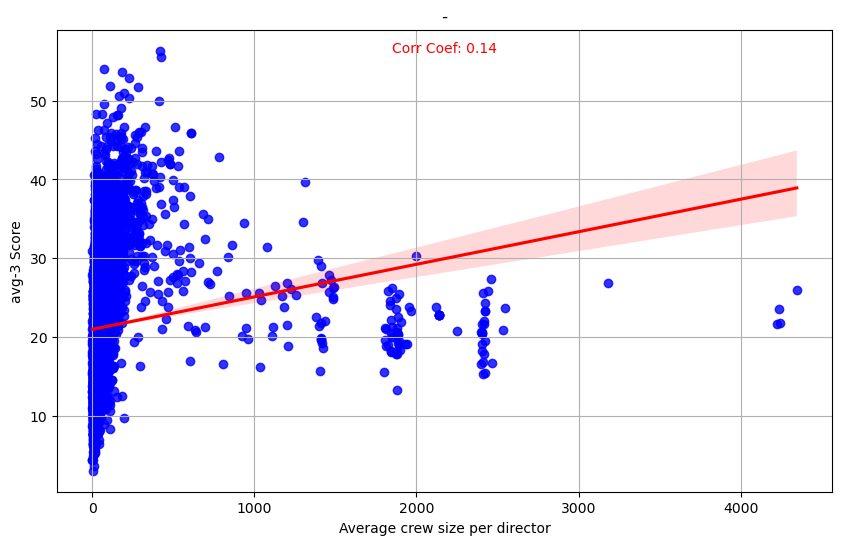

In [36]:
tmp_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3']).copy()
tmp_df[['avg_crew_size', 'avg-3']] = tmp_df[['avg_crew_size', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=tmp_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

correlation_coefficient = tmp_df['avg_crew_size'].corr(tmp_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew size per director')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

Interesting behaviour : seems like for movies inferior to a certain size there is a correlation between avg-3 score of the director and his/her average crew size but this is unbalanced when taking the movies superior to a certain size. Let's separate the directors in two to see how the two 'director' populations behave :

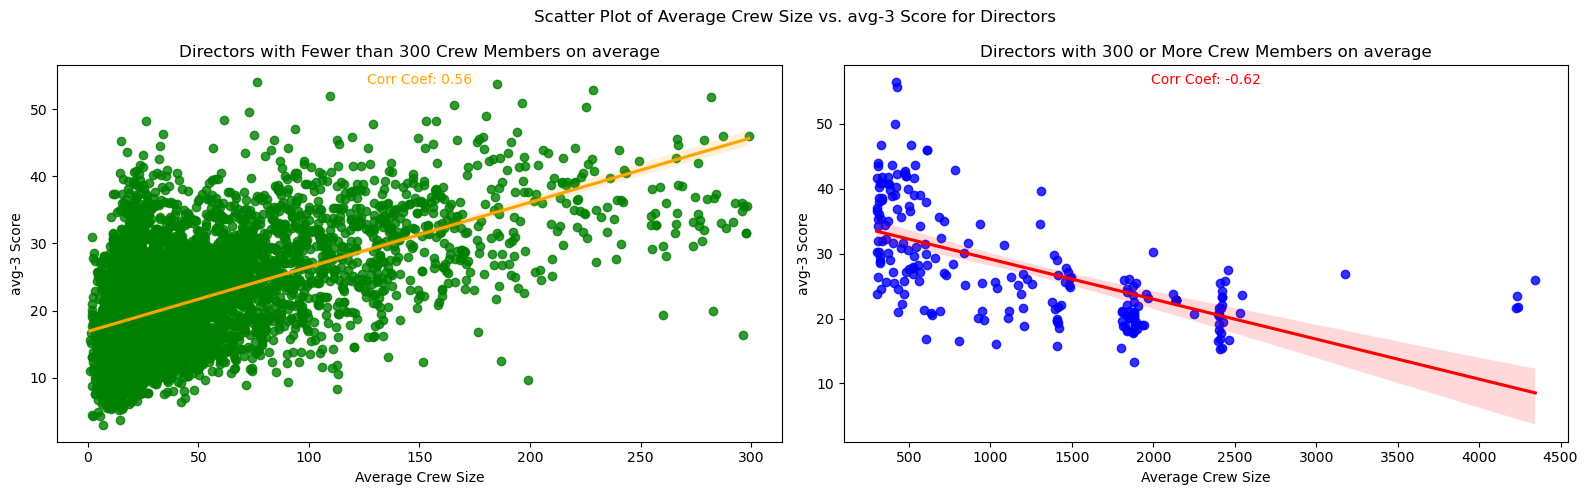

In [33]:
large_crew_directors = tmp_df[tmp_df['avg_crew_size'] >= 300]
small_crew_directors = tmp_df[tmp_df['avg_crew_size'] < 300]

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# For small crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=small_crew_directors, scatter_kws={'color': 'green'}, line_kws={'color': 'orange'}, ax=axes[0])
correlation_coefficient = small_crew_directors['avg_crew_size'].corr(small_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='orange')
axes[0].set_title('Directors with Fewer than 300 Crew Members on average')

# For large crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=large_crew_directors, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ax=axes[1])
correlation_coefficient = large_crew_directors['avg_crew_size'].corr(large_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
axes[1].set_title('Directors with 300 or More Crew Members on average')


fig.suptitle('Scatter Plot of Average Crew Size vs. avg-3 Score for Directors')
for ax in axes:
    ax.set_xlabel('Average Crew Size')
    ax.set_ylabel('avg-3 Score')

plt.tight_layout()
plt.show()

Could mean that the crew size has an impact until a certain point. Passed a certain threshold, the director's success correlates negatively with its team size.

Budget could be a cofounder, but we unfortunately do not have the info.

---
## Are the directors who always work with the same crew more successful?

Now, let's try to see what's the behaviour of the number of collaborations of each director's. How many directors tend to work with similar people across their directed movies ? 

In [37]:
tmp_dir_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3']).copy()

In [38]:
def get_movie_crew(movies,matched_people) :
    
    crew = matched_people.copy()
    tqdm.pandas(desc="knownForTitles under str form")
    crew['knownForTitles'] = crew['knownForTitles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    tqdm.pandas(desc="all_known_roles under str form")
    crew['all_known_roles'] = crew['all_known_roles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())

    tqdm.pandas(desc="Taking union of knownForTitles & all_known_roles")
    roles_df = crew[['knownForTitles', 'all_known_roles']].progress_apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)
    roles_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_df})
    #roles_df = roles_df.explode('roles_union')

    tt_nconst_mapping = {}
    selected_movies = set(movies.index)
    # Iterate through each row and update the dictionary
    rows = []
    for index, row in tqdm(roles_df.iterrows(), total=len(roles_df), desc="Finding crew members", leave=False):
        nconst_id = row['nconst']
        tt_ids = row['roles_union']

        for tt_id in tt_ids:
            if tt_id in selected_movies:
                rows.append({'nconst': nconst_id, 'roles_union': tt_id})

    roles_df = pd.DataFrame(rows)

    # Group by 'roles_union' and aggregate 'nconst' as a list
    tt_nconst_mapping = roles_df.groupby('roles_union')['nconst'].agg(list).to_dict()

    return tt_nconst_mapping

In [39]:
movie_crews = get_movie_crew(movies_wcs,mip_enhanced)

Taking union of knownForTitles & all_known_roles: 100%|██████████| 2865101/2865101 [00:35<00:00, 81501.18it/s]


Lots of unnecessary copying and re-declaration of variables, clean this up.

In [40]:
def overlap_coefficient(set1, set2):
    intersection_size = len(set1.intersection(set2))
    min_size = min(len(set1), len(set2))
    return intersection_size / min_size if min_size > 0 else 0


filtered_directors = directors.dropna(subset=['avg-3'])
directors_copy = filtered_directors.copy()
directors_copy['avg_crew_change'] = 0.0 


for index, row in tqdm(filtered_directors.iterrows(), total=len(filtered_directors), desc="Finding crew similarities for the directors", leave=False) :
    director_id = index
    directed_movies = row['directed_movies'].split(',')

    # Get the set of crew members for each movie directed by the director
    director_crews = [set(movie_crews[movie_id]) for movie_id in directed_movies if movie_id in movie_crews]

    # Calculate crew changes
    crew_changes = []
    for i in range(len(director_crews) - 1):
        for j in range(i + 1, len(director_crews)):
            overlap_coeff = overlap_coefficient(director_crews[i], director_crews[j])
            crew_changes.append(overlap_coeff)

    # Calculate the average crew change for the director
    avg_crew_change = sum(crew_changes) / len(crew_changes) if crew_changes else 0
    directors_copy.at[index, 'avg_crew_change'] = avg_crew_change

Finding crew similarities for the directors:   0%|          | 0/6508 [00:00<?, ?it/s]

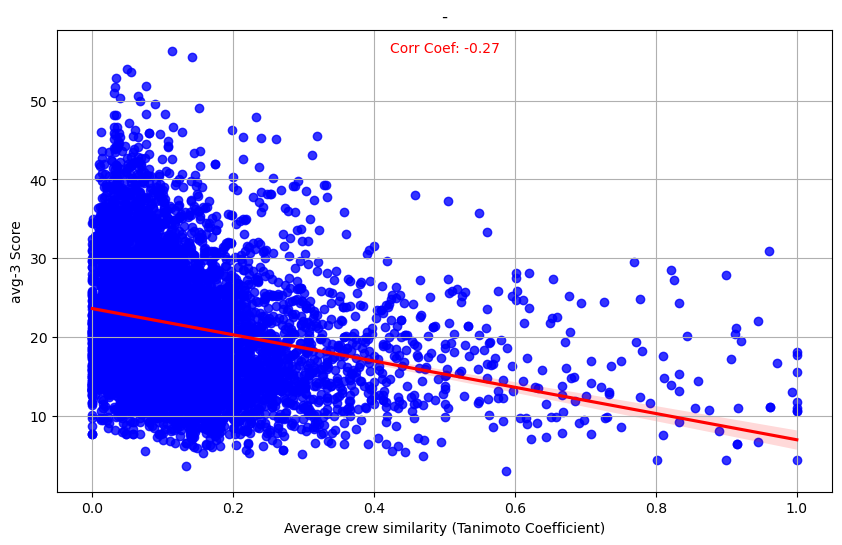

In [41]:
directors_copy = directors_copy.dropna(subset=['avg_crew_change', 'avg-3']).copy()
directors_copy[['avg_crew_change', 'avg-3']] = directors_copy[['avg_crew_change', 'avg-3']].apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_change', y='avg-3', data=directors_copy, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

correlation_coefficient = directors_copy['avg_crew_change'].corr(directors_copy['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew similarity (Tanimoto Coefficient)')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [95]:
#directors_copy = pd.merge(directors_copy,tmp_dir_df['avg_crew_size'],left_index=True,right_index=True)

In [96]:
#plt.figure(figsize=(10, 6))
#ax = sns.regplot(x='avg_crew_change', y='avg_crew_size', data=directors_copy, scatter_kws={'color': 'blue'})
#
#correlation_coefficient = directors_copy['avg_crew_change'].corr(directors_copy['avg_crew_size'])
#plt.title('-')
#plt.xlabel('Average crew similarity (Overlap Coefficient)')
#plt.ylabel('Average crew size')
#plt.grid(True)
#plt.show()

------
## Is directors' success related to the presence of certain individuals in their team ? If yes, how frequently have they been collaborating with each other ?

Considering the entire crew gives insights (see above + graphs), but let's now focus on the presence or not of certain individuals.

Here, we take the 5 best films (in terms of score) of the directors and identify if some crew members were present in at least 4 of them. (Numbers can be changed, just to see)

In [122]:
from collections import Counter

directors_with_at_least_5_movies = directors_copy[directors_copy['directed_movies'].apply(lambda x: len(str(x).split(',')) >= 5)]
directors_core = directors_with_at_least_5_movies.copy()
directors_core['core_crew'] = None

#Identify core crew members for each director with the top 5 highest-scored movies
for index, row in tqdm(directors_core.iterrows(),total=len(directors_core),desc="Identifying core members in directors' successes"):
    director_id = index
    directed_movies_str = row['directed_movies']

    # Convert the comma-separated string of movie ids to a list
    directed_movies = directed_movies_str.split(',')

    # Fetch the top 5 highest-scored movies for the director
    top_5_movies = (
        pd.DataFrame(directed_movies, columns=['tconst'])
        .merge(movies[['score']], left_on='tconst', right_index=True)
        .nlargest(5, 'score')
    )
    
    # Get the set of crew members for each of the top 5 movies
    director_crews = [set(movie_crews[movie_id]) for movie_id in top_5_movies['tconst'] if movie_id in movie_crews]

    # Count occurrences of each crew member across all movies, excluding the director
    total_movie_count = len(top_5_movies)
    all_crew_members = [crew_member for crew_set in director_crews for crew_member in crew_set if crew_member != director_id]
    crew_member_counts = Counter(all_crew_members)

    # Identify core crew members (appearing in at least 80% of the top 5 movies)
    core_crew = [crew_member for crew_member, count in crew_member_counts.items() if count >= 0.6 * total_movie_count]

    # Store the core crew members in the new column
    directors_core.at[index, 'core_crew'] = core_crew

Identifying core members in directors' successes:   0%|          | 0/3694 [00:00<?, ?it/s]

Identifying core members in directors' successes: 100%|██████████| 3694/3694 [01:42<00:00, 35.94it/s]


In [123]:
directors_core['core_crew_count'] = directors_core['core_crew'].apply(lambda x: len(str(x).split(',')) if x else 0)
directors_core.sort_values(by='avg-3',ascending=False).head(15)

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,avg-10,hits-30,hits-40,hits-45,hits-50,...,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,directed_movies,avg_crew_change,avg_crew_size,core_crew,core_crew_count
nconst,,,,,,,,,,,,,,,,,,,,,
nm0634240,Christopher Nolan,1970,<NA>,"writer,producer,director","tt0816692,tt1375666,tt6723592,tt0482571",48.277678,9,7,7,7,...,8,7,4,56.359359,54.76424,"tt0278504,tt0411302,tt0154506,tt0209144,tt0468...",0.113881,420.200000,"[nm0634300, nm0390911, nm0000288, nm4871836, n...",18
nm0001392,Peter Jackson,1961,<NA>,"producer,director,writer","tt0120737,tt0167261,tt0360717,tt0092610",40.917419,9,4,3,3,...,4,3,3,55.600284,48.992753,"tt0167261,tt0116365,tt0110005,tt0092610,tt0314...",0.141339,424.384615,"[nm0125558, nm1403200, nm1398127, nm1398757, n...",618
nm0000338,Francis Ford Coppola,1939,<NA>,"producer,director,writer","tt0078788,tt0071562,tt0068646,tt0071360",42.252444,10,4,3,2,...,6,4,3,54.015733,48.884288,"tt1756851,tt0064873,tt0153167,tt0809488,tt0071...",0.048656,76.466667,"[nm0000473, nm0292875, nm0178874, nm0932336, n...",11
nm0000233,Quentin Tarantino,1963,<NA>,"writer,actor,producer","tt7131622,tt0110912,tt0105236,tt0116367",47.488598,11,8,7,4,...,9,7,2,53.710729,52.175466,"tt0119396,tt0378194,tt0266697,tt1853728,tt0462...",0.054518,184.833333,"[nm0579673, nm0004744, nm0913300, nm0724744]",4
nm0000229,Steven Spielberg,1946,<NA>,"producer,writer,director","tt0083866,tt0108052,tt0082971,tt0120815",48.343442,25,13,7,3,...,15,7,2,52.930622,51.378904,"tt0408306,tt1568911,tt0249968,tt0407304,tt0118...",0.033394,228.484848,[nm0002354],1
nm0000217,Martin Scorsese,1942,<NA>,"producer,director,actor","tt0106226,tt0075314,tt0099685,tt0070379",47.283685,25,10,7,4,...,22,12,3,51.938314,50.997257,"tt0061402,tt0893382,tt0068309,tt1151319,tt0057...",0.076066,109.333333,"[nm0000138, nm0110631]",2
nm0000399,David Fincher,1962,<NA>,"producer,director,writer","tt0443706,tt2267998,tt0114369,tt1285016",<NA>,9,7,4,2,...,7,2,2,51.770668,49.031727,"tt0103644,tt0119174,tt1568346,tt0137523,tt0421...",0.032482,281.777778,"[nm0006866, nm0149556, nm0000093, nm1285873]",4
nm0000709,Robert Zemeckis,1952,<NA>,"producer,writer,director","tt0118884,tt1907668,tt0088763,tt0109830",43.218293,14,8,3,2,...,6,2,2,50.947567,47.926824,"tt0096874,tt0161081,tt0096438,tt1067106,tt0088...",0.030544,196.500000,"[nm0006293, nm0279427, nm0134635, nm0519568, n...",14
nm0001104,Frank Darabont,1959,<NA>,"writer,producer,director","tt0111161,tt0120689,tt1520211,tt0884328",<NA>,4,2,2,2,...,2,2,2,50.632830,41.74305,"tt0099188,tt0111161,tt0884328,tt0268995,tt0120689",0.065492,165.400000,"[nm0000175, nm1044052, nm0218810]",3


Our most successful directors nearly all have some key relationships, some more than others. But do the number of core relationships correlates with the avg-3 score of the director ?

(Removing Peter Jackson & potential other outliers that worked with the exact same people on all the movies)

In [126]:
model = smf.ols('Q("avg-3") ~ core_crew_count', data=directors_core[directors_core['core_crew_count'] < 100]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("avg-3")   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     209.2
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.60e-46
Time:                        13:32:40   Log-Likelihood:                -12946.
No. Observations:                3691   AIC:                         2.590e+04
Df Residuals:                    3689   BIC:                         2.591e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          22.2466      0.151    1

The R^2 squared is terrible, but slight (significant) positive correlation between the number of core relationships and the success metric of the director. The close relationships of directors with members of the industry over their best films seem to be correlated with success.

How about with all of the three 'new' metrics we just had ?

In [127]:
tmp = directors_core[(directors_core['core_crew_count'] < 100) & (directors_core['avg_crew_size'] > 10)]
model = smf.ols('Q("avg-3") ~ core_crew_count + avg_crew_change + avg_crew_size ', data=tmp).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("avg-3")   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     326.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          2.69e-186
Time:                        13:34:15   Log-Likelihood:                -11703.
No. Observations:                3447   AIC:                         2.341e+04
Df Residuals:                    3443   BIC:                         2.344e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          25.6523      0.227    1

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_change', y='avg-3', data=directors_copy, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

correlation_coefficient = directors_copy['avg_crew_change'].corr(directors_copy['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew similarity (Tanimoto Coefficient)')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

As we already saw in other individual parts :

- The number of core relations in between movies for directors is linearily correlated with its success score

- The average crew change is negatively correlated with success : directors that change their entire crew often are correlated with diminished scores

- The crew size has a very small positive impact, it seems, on the score of the movie. Be careful with this one as we saw it can clearly be cofounded by budget for instance, and that the individual value does not really have the same distribution for all directors

**The r squared is pretty bad : try adding non linearity, as we saw the individual variables had some non-linear behaviours with the score, or stuff like that?**

Now what we can try to do is to take all of these core relationships and identify some people that are maybe common to a lot of these successful directors.

In [191]:
test = directors_core.copy()
test = test.dropna(subset=['core_crew'])  # Remove rows with missing core_crew values
test['num_movies_directed'] = test['directed_movies'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
model = smf.ols('core_crew_count ~ num_movies_directed', data=test).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        core_crew_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03641
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.849
Time:                        15:29:14   Log-Likelihood:                -14182.
No. Observations:                3694   AIC:                         2.837e+04
Df Residuals:                    3692   BIC:                         2.838e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.1131    

The number of core relationships probably isn't just a 'side-effect' of the number of movies directed by a director. There is something more to them. 
(Also checked with a scatter plot although not put here right now, make it more explicit).

The code below is just to try and cluster directors based on their core relationship, but it does not work very well. The name probably doesn't matter...

In [202]:
#import pandas as pd
#from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#
## Assuming 'directors_core' is your DataFrame
#test = directors_core.copy()
#test = test.dropna(subset=['core_crew'])  # Remove rows with missing core_crew values
#
## Use MultiLabelBinarizer for one-hot encoding
#mlb = MultiLabelBinarizer()
#core_crew_encoded = pd.DataFrame(mlb.fit_transform(test['core_crew']), columns=mlb.classes_, index=test.index)
#
## Use DBSCAN for clustering
#dbscan = DBSCAN(eps=10, min_samples=5)  # You may need to adjust eps and min_samples
#cluster_labels = dbscan.fit_predict(core_crew_encoded)
#
## Print the number of clusters (-1 indicates outliers)
#num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
#print(f"Number of clusters: {num_clusters}")
#
## If you want to evaluate the silhouette score, uncomment the lines below
## silhouette_avg = silhouette_score(core_crew_encoded, cluster_labels)
## print(f"Silhouette Score: {silhouette_avg}")
#
## Assign cluster labels to the DataFrame
#test['cluster'] = cluster_labels
#
## Display the resulting clusters
#print(test[['cluster']])

... but what about the jobs of these persons ? How is success of directors related to the professions of people in their core crew ? (We one-hot encode variable for profession, 0 if the profession is not part of the core crew of the director, 1 if it is)

In [295]:
mip = mip_enhanced.set_index('nconst')
result_df = pd.DataFrame()

# Iterate through each row in directors_core dataframe
for index, row in tqdm(directors_core.iterrows(), total=len(directors_core)):
    director_id = index
    core_crew_list = row['core_crew']

    # Find the corresponding rows in mip_enhanced
    crew_member_rows = mip[mip.index.isin(core_crew_list)]
    # Flatten and unique list of professions
    professions = crew_member_rows['primaryProfession'].str.split(',').explode().unique()

    # Create a temporary dataframe for the current director
    temp_df = pd.DataFrame({'nconst': director_id}, index=[0])

    # Create binary columns indicating presence of each profession
    for profession in professions:
            temp_df[profession] = int(1)

    # Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Fill NaN values with 0
result_df = result_df.fillna(int(0))

final_result = pd.merge(directors_core, result_df, on='nconst', how='left')

100%|██████████| 3694/3694 [07:08<00:00,  8.63it/s]


In [332]:
result_df = result_df.set_index('nconst')
ml_df = pd.merge(directors_core['avg-3'], result_df, left_index=True,right_index=True)

Mean Squared Error: 64.6973943289201


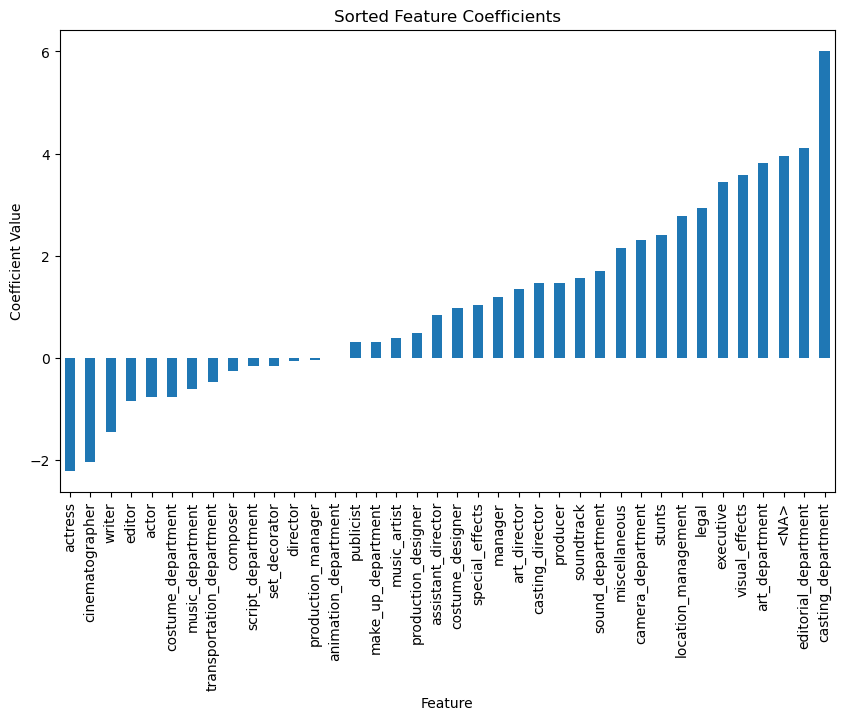

In [340]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your data is in a DataFrame named 'df'
features = ml_df.drop('avg-3', axis=1)
target = ml_df['avg-3']

# Convert column names to strings
features.columns = features.columns.astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Coefficients (feature importance)
coefficients = pd.Series(model.coef_, index=features.columns)

coefficients_sorted = coefficients.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
coefficients_sorted.plot(kind='bar')
plt.title('Sorted Feature Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.show()

Cinematographer and writer with negative correlations ? Investigate, seems weird from an outside perspective.

In [329]:
#import pandas as pd
#from kmodes.kmodes import KModes
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import silhouette_score
#
## Load your data into the result_df dataframe
#crew_type = result_df.set_index('nconst')
#
## Specify a range of cluster values to test
#cluster_range = range(40, 80)  # Adjust the range as needed
#
#silhouette_scores = []
#best_silhouette_score = -1
#optimal_n_clusters = None
#
#for n_clusters in cluster_range:
#    # Create KModes instance and fit the model
#    km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
#    clusters = km.fit_predict(crew_type)
#
#    # Calculate silhouette score
#    silhouette_avg = silhouette_score(crew_type, clusters)
#    silhouette_scores.append(silhouette_avg)
#    
#    # Update optimal number of clusters if the silhouette score is better
#    if silhouette_avg > best_silhouette_score:
#        best_silhouette_score = silhouette_avg
#        optimal_n_clusters = n_clusters
#
## Fit the KModes model with the optimal number of clusters
#optimal_km = KModes(n_clusters=optimal_n_clusters, init='Huang', n_init=5, verbose=0)
#optimal_clusters = optimal_km.fit_predict(crew_type)
#
## Add the optimal cluster labels back to the original dataframe
#crew_type['optimal_cluster'] = optimal_clusters
#
## Display the cluster assignments for the optimal number of clusters
#columns_to_display = ['optimal_cluster']
#
#print('Optimal number of clusters found through K-modes : ',  str(optimal_n_clusters))
#plt.plot(cluster_range, silhouette_scores, marker='o')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score for Different Numbers of Clusters')
#plt.show()

In [328]:
#columns_to_plot = ['avg-3', 'optimal_cluster']
#final_result = pd.merge(directors_core,crew_type['optimal_cluster'],left_index=True,right_index=True)
#df_to_plot = final_result[columns_to_plot]
#
## Group by 'optimal_cluster' and calculate the mean for 'avg-3' in each cluster
#avg_scores_by_cluster = df_to_plot.groupby('optimal_cluster')['avg-3'].mean()
#
## Plot the bar chart
#plt.figure(figsize=(10, 6))
#avg_scores_by_cluster.plot(kind='bar', color='skyblue')
#plt.title('Average avg-3 Scores by Cluster')
#plt.xlabel('Cluster')
#plt.ylabel('Average avg-3 Score')
#plt.show()

----------------

## Work on graphs

The idea here is to build a graph using the collaboration counts that we extracted earlier. One node per director and by person in the many different crews, the edge linking the both being weighted by their number of collaborations. The graph is constructed in such a manner that directors-directors (if two directors direct the same films) are not counted in the graph : ONLY crew-directors interactions --> bipartite graph.

This was done with the idea was thus to build the bipartite (cf. Lecture 12) projection of this graph on the directors only. We would have one node per director and edges linking these edges depending on the similarity they had in terms of collaborations in their films. This is done to identify clusters of directors with similar crews to potentially be able to retrieve cluster(s) of successful directors, based on their crew composition.

In [242]:
from networkx.algorithms import bipartite
def building_bipartite_projection(collab_counts,wanted_directors,all_directors) :
    
    graph = nx.Graph()

    directors_set = set()
    collaborators_set = set()

    for director, collaborators in tqdm(collab_counts.items(),total=len(collab_counts),desc="Building a graph of all collaborations"):
        if director in wanted_directors :
            if director not in directors_set:
                graph.add_node(director, bipartite=0)
                directors_set.add(director)

            for collaborator, collaborations_count in collaborators.items():
                if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                    if collaborator not in collaborators_set:
                        graph.add_node(collaborator, bipartite=1)
                        collaborators_set.add(collaborator)

                    if collaborator not in collab_counts.keys() : 
                        if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                            graph.add_edge(director, collaborator, weight=collaborations_count)
    print('The Graph is Bipartite :', str(bipartite.is_bipartite(graph)))          
    directors_nodes = {node for node, data in graph.nodes(data=True) if data['bipartite'] == 0}
    directors_projection = nx.bipartite.weighted_projected_graph(graph, directors_nodes, ratio=False)

    return(directors_nodes,directors_projection)

Function is defined to build this bipartite projection for only the directors that we want (inclusion of 'all_directors' is to not add edges between two directors). (Takes ~10 mins to run)

In [243]:
curr_node, curr_bip_proj = building_bipartite_projection(collab_counts,directors_copy.index,directors.index)

Building a graph of all collaborations: 100%|██████████| 6508/6508 [00:26<00:00, 241.62it/s]


The Graph is Bipartite : True


In that bipartite graph, let's try to find the directors with the highest degree centrality : the ones that share most similarities with other directors in terms of different collaborations they had throughout their career. Are these only successful directors ? (this is only an idea, maybe the metric to retrieve is not the best)

In [264]:
def retrieve_degree_centrality(graph):
    """
    Finds the directors with the highest degree centrality : the directors that are the most 'well-connected' to the rest of the network.
    """
    dcs = pd.Series(nx.degree_centrality(graph))
    return dcs

In [283]:
dcs = retrieve_degree_centrality(curr_bip_proj)
dcs = pd.DataFrame({'nm_id': dcs.index, 'degree_centrality': dcs.values})
dcs.set_index('nm_id', inplace=True)
directors_dc = pd.merge(directors_copy,dcs,left_index=True,right_index=True)

In [290]:
directors_dc.sort_values(by='degree_centrality',ascending=False).head(10)

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10,directed_movies,avg_crew_change,community,degree_centrality
nm0000229,Steven Spielberg,1946,<NA>,"producer,writer,director","tt0083866,tt0108052,tt0082971,tt0120815",25,13,7,3,21,15,7,2,52.930622,51.378904,48.343442,"tt0408306,tt1568911,tt0249968,tt0407304,tt0118...",0.006063,13.0,0.360227
nm0000265,Robert Altman,1925,2006,"director,producer,writer","tt0073440,tt0105151,tt0108122,tt0280707",8,0,0,0,15,6,0,0,36.035712,35.583352,33.527768,"tt0068732,tt0050558,tt0072274,tt0066026,tt0050...",0.012516,NaN,0.349623
nm0000095,Woody Allen,1935,<NA>,"writer,director,actor","tt0118954,tt0075686,tt0079522,tt0091167",32,4,0,0,24,10,1,0,42.353831,41.161361,38.865405,"tt1859650,tt0066808,tt0086637,tt1182350,tt0104...",0.018618,13.0,0.310742
nm0000217,Martin Scorsese,1942,<NA>,"producer,director,actor","tt0106226,tt0075314,tt0099685,tt0070379",25,10,7,4,33,22,12,3,51.938314,50.997257,47.283685,"tt0061402,tt0893382,tt0068309,tt1151319,tt0057...",0.013342,13.0,0.308591
nm0000631,Ridley Scott,1937,<NA>,"producer,director,production_designer","tt0083658,tt0172495,tt0103074,tt3659388",16,6,3,2,12,6,3,2,50.392010,47.693042,43.326279,"tt0094008,tt0119173,tt0758774,tt1446714,tt0118...",0.005717,13.0,0.302290
nm0001149,Richard Donner,1930,2021,"director,producer,actor","tt0089457,tt0078346,tt0093409,tt0839995",15,2,0,0,8,4,0,0,40.764547,39.800411,37.32231,"tt0078346,tt0075005,tt0450232,tt0093409,tt0081...",0.010899,13.0,0.299677
nm0001239,John Frankenheimer,1930,2002,"director,miscellaneous,producer","tt0056218,tt0119189,tt0116654,tt0058576",5,0,0,0,10,4,0,0,36.667181,35.217948,31.366832,"tt0073018,tt0079758,tt0067216,tt0060955,tt0122...",0.017806,13.0,0.294913
nm0000776,Michael Apted,1941,2021,"director,producer,miscellaneous","tt0095243,tt0143145,tt0157583,tt0384766",6,0,0,0,6,2,0,0,33.146450,32.772145,30.871941,"tt0110638,tt0218433,tt0092798,tt0110583,tt0980...",0.009916,NaN,0.289073
nm0001486,Sidney Lumet,1924,2011,"director,producer,writer","tt0050083,tt0070666,tt0292963,tt0072890",12,3,1,1,17,10,4,1,46.333794,43.033343,38.581793,"tt0376215,tt0080975,tt0062768,tt0052832,tt0292...",0.021507,13.0,0.285078
nm0000165,Ron Howard,1954,<NA>,"producer,actor,writer","tt0112384,tt0268978,tt0075213,tt0367279",15,4,2,0,7,5,3,0,45.847882,43.731106,39.804226,"tt1578275,tt0131369,tt0110771,tt0338188,tt0088...",0.007999,13.0,0.282004


In [289]:
model = smf.ols('Q("avg-3") ~ degree_centrality', data=directors_dc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Q("avg-3")   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     4226.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:54:29   Log-Likelihood:                -21102.
No. Observations:                6508   AIC:                         4.221e+04
Df Residuals:                    6506   BIC:                         4.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.3158      0.10

Nice ! Directors displayed mainly contains directors that are successful to very successful, and the degree centrality is (significantly) correlated with the avg-3 score + R^2 is actually very decent for a single variable.

### Todo on graphs : investigate on what else we can get out of it ! Nice visualizations and stuff (other graphs maybe)

In [261]:
#communities = list(community.louvain_communities(curr_bip_proj))
#community_labels = {director: i for i, community in enumerate(communities) for director in community}
#
#for community in communities :
#    print(len(community))
#
#node_colors = [community_labels[node] for node in curr_bip_proj.nodes]
#pos = nx.spring_layout(curr_bip_proj)  # You can use other layout algorithms
#nx.draw_networkx_nodes(curr_bip_proj, pos, node_color=node_colors, node_size=0.1, cmap=plt.cm.Blues)
#plt.show()

In [187]:
#nconst_to_community = {nconst: i for i, community_set in enumerate(communities) for nconst in community_set}
#
#directors_copy['community'] = directors_copy.index.map(nconst_to_community)
#
#community_avg_scores = directors_copy.groupby('community')['avg-3'].mean()

In [601]:
#all_professions = [
#    profession.strip()
#    for profession_list in mip_enhanced['primaryProfession'].str.split(',')
#    if isinstance(profession_list, list)  # Check if it's a list
#    for profession in profession_list
#    if pd.notna(profession)
#]
#
## Get unique professions by converting the list to a set
#unique_professions = set(all_professions)
#
## Convert the set back to a list if needed
#unique_professions_list = list(unique_professions)
#
## Print or use the list as needed
#print(unique_professions_list)

['stunts', 'executive', 'script_department', 'editor', 'art_director', 'editorial_department', 'costume_designer', 'soundtrack', 'assistant_director', 'animation_department', 'transportation_department', 'special_effects', 'production_manager', 'podcaster', 'production_department', 'camera_department', 'publicist', 'talent_agent', 'make_up_department', 'assistant', 'cinematographer', 'set_decorator', 'manager', 'costume_department', 'writer', 'music_artist', 'miscellaneous', 'composer', 'sound_department', 'location_management', 'legal', 'casting_director', 'production_designer', 'music_department', 'producer', 'art_department', 'visual_effects', 'actor', 'director', 'casting_department', 'actress']


In [473]:
#import statsmodels.formula.api as smf
#model = smf.ols('score ~ crew_size', data=movies_wscs).fit()
#print(model.summary())

---
### How are both experience ( i.e how many movies people have directed / worked on etc.) & diversity in their career linked to movie success ?

- See how this overlaps with the two others, as number of movies is still important in both of them

- See if the primaryProfessions of the directors have an influence on the success of the latter

In [237]:
experience_info = directors[['primaryName','primaryProfession','avg-3','directed_movies']]

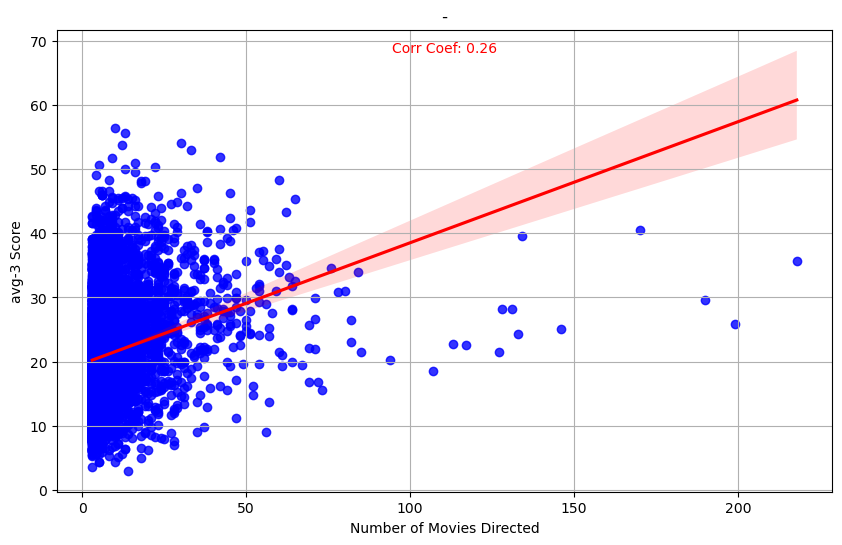

In [217]:
experience_info_filtered = experience_info.copy()
experience_info_filtered['num_movies_directed'] = experience_info_filtered['directed_movies'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

experience_info_filtered['avg-3'] = pd.to_numeric(experience_info['avg-3'], errors='coerce')
experience_info_filtered['num_movies_directed'] = pd.to_numeric(experience_info['num_movies_directed'], errors='coerce')
experience_info_filtered = experience_info.dropna(subset=['avg-3']) ## DROPPING THE NAN AVG-3 VALUE, MODIFY IF SCORE CHANGES

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='num_movies_directed', y='avg-3', data=experience_info_filtered, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

correlation_coefficient = experience_info_filtered['num_movies_directed'].corr(experience_info_filtered['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Number of Movies Directed')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

C:\Users\dryha\AppData\Local\Temp\ipykernel_18456\1111843461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_info_filtered[profession] = experience_info_filtered['primaryProfession'].apply(lambda x: 1 if profession in x else 0)


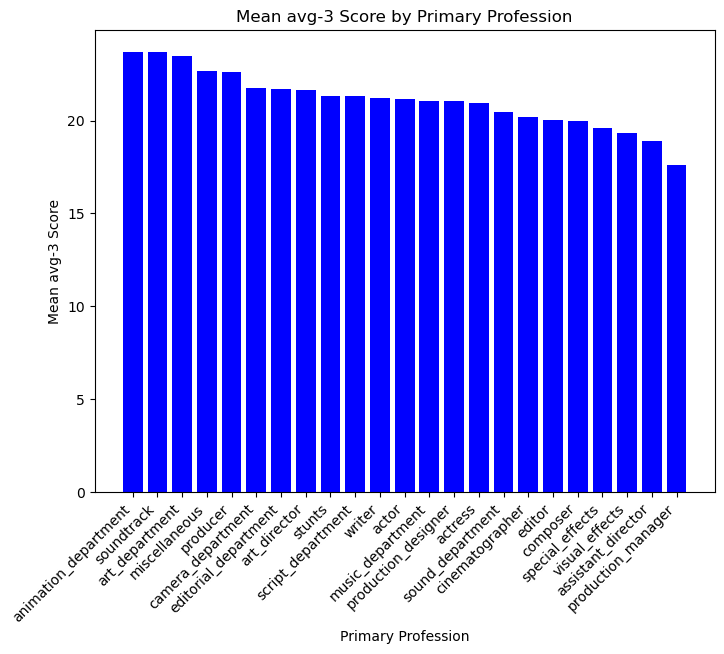

In [240]:
unique_professions = set(','.join(experience_info_filtered['primaryProfession']).split(','))

# Create dummy variables for each unique profession
for profession in unique_professions:
    experience_info_filtered[profession] = experience_info_filtered['primaryProfession'].apply(lambda x: 1 if profession in x else 0)

# Filter and calculate mean 'avg-3' for directors who were also actors, producers, etc.
mean_avg3_by_profession = {}
for profession in unique_professions:
        if profession != 'director' :
            director_count = experience_info_filtered[experience_info_filtered[profession] == 1].shape[0]
            if director_count > 20:
                filtered_data = experience_info_filtered[experience_info_filtered[profession] == 1]
                mean_avg3_by_profession[profession] = filtered_data['avg-3'].mean()

# Sort values based on mean 'avg-3' scores
sorted_professions = sorted(mean_avg3_by_profession.items(), key=lambda x: x[1], reverse=True)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.bar([item[0] for item in sorted_professions], [item[1] for item in sorted_professions], color='blue')
plt.title('Mean avg-3 Score by Primary Profession')
plt.xlabel('Primary Profession')
plt.ylabel('Mean avg-3 Score')
plt.xticks(rotation=45, ha='right')
plt.show()

-----
### Are some directors successful only because they cast popular actors ?

- Find out how to measure what 'popular actors' are. Actors that features in popular movies, do we take awards into account as we're talking about popularity here ?

- This could also overlap with 'the presence of certain individuals in their team' if we find out that we have many actors. But this could be a complement to the other one : we find that some people have an influence for directors, and that maybe the majority of them are actors, or the other way around.

In [361]:
actors_and_actresses = pd.DataFrame(jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])]['nconst'].unique()).rename(columns={0:'nconst'})

# Count the number of movies for each actor in jobs_principal_people
actor_movie_counts = jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])].groupby('nconst')['tconst'].count()

# Filter out actors who have less than 3 movies
valid_actors_initial = actor_movie_counts[actor_movie_counts >= 3].index

In [362]:
tmp_mip = mip_enhanced[mip_enhanced['nconst'].isin(valid_actors_initial)].copy()
tmp_mip = pd.merge(tmp_mip,actors_and_actresses,on='nconst')
tmp_mip['known_titles_list'] = tmp_mip['knownForTitles'].str.split(',')
exploded_people_df = tmp_mip.explode('known_titles_list')
merged_df = pd.merge(exploded_people_df, movies, left_on='known_titles_list', right_index=True, how='left')
merged_df['score'] = pd.to_numeric(merged_df['score'], errors='coerce')
# Filter out NaN scores
merged_df_filtered = merged_df.dropna(subset=['score'])
# Calculate the number of movies per person
movie_count_per_person = merged_df_filtered.groupby('nconst')['score'].count()
# Filter out individuals with less than 4 movies
valid_people = movie_count_per_person[movie_count_per_person >= 3].index
# Filter the merged dataframe for valid people
valid_merged_df = merged_df_filtered[merged_df_filtered['nconst'].isin(valid_people)]
# Calculate the number of movies per person in the original movies dataframe
movie_count_per_person_original = valid_merged_df.groupby('nconst').size()

# Filter out individuals with less than 3 movies in the original movies dataframe
final_valid_people = movie_count_per_person_original[movie_count_per_person_original >= 3].index

# Filter the merged dataframe for final valid people
final_valid_merged_df = valid_merged_df[valid_merged_df['nconst'].isin(final_valid_people)]

# Calculate the average score and primary name for each person
average_scores = final_valid_merged_df.groupby('nconst').agg({'score': 'mean', 'primaryName': 'first'})

In [368]:
average_scores.sort_values(by = 'score',ascending=False).head(15)

,score,primaryName
nconst,,
nm0597480,55.600284,Dominic Monaghan
nm0722636,54.313503,John Rhys-Davies
nm0000704,54.192630,Elijah Wood
nm0915989,54.129134,Hugo Weaving
nm0089217,53.993161,Orlando Bloom
nm0362766,52.512383,Tom Hardy
nm0000276,52.215807,Sean Astin
nm0493200,52.115059,Denis Lawson
nm0000402,52.115059,Carrie Fisher


We have a list of only actors/actresses that played in several movies as 'leading' roles. We can only keep the ones superior to a certain threshold to have a measure of 'success'/'popularity'. See how often directors starred these persons in particular and see what we can get out of it.

### Can we find directors that decided to cast, for their next project, only very popular actors by looking at details about their previous work ?



- Need to have a temporal analysis for this one, i.e the release dates of the movies. Maybe define a 'actors popularity' metric for the movies and see how this changes with respect to time with directors and their movie success. This could also overlap with the previous question 

### More directors = More success ?

- Some films have several directors. While we do not know exactly (maybe we can have some info with the principals dataframe) how they collaborate, seeing if movies with several directors behave better or not can be interesting. Is monarchy or democracy better when creating a film ?

### Add other questions to complete the others if they come to mind

---------
--------
--------
-----
------
--------
--------
-------
# Unrelated previous Work on metrics

In [ ]:
from helpers.readers import read_dataframe
awards = read_dataframe('imdb/awards')

## Including the awards in movie success

In [ ]:
#Only keeping the movies awards for now, discarding the ones for the actors.
movie_awards = awards[awards['isTitle']]
cmu_imdb_awards = pd.merge(movie_awards,movies['tconst'], left_on='const',right_on='tconst',how='inner').drop(columns=['tconst'])
cmu_imdb_awards.const.nunique()

29038

In [ ]:
nominations_per_movie = cmu_imdb_awards.groupby(['const', 'eventName', 'year']).agg({
    'categoryName': ['size', lambda x: ', '.join(x.fillna('Not mentioned'))],
    'isWinner': lambda x: x.tolist()
}).reset_index()

# Rename the columns for clarity
nominations_per_movie.columns = ['tconst', 'eventName', 'year', 'numNominations', 'nominationsList', 'isWinnerList']

What i try to do here is to use :
- The number of events the movie was nominated in
- The total movie nominations
- The total number of wins within those nominations

And to have a weighted sum of  (the log of) these three factors. Can surely be improved, most likely not optimal

In [ ]:
movies_total_events = nominations_per_movie.groupby(['tconst', 'eventName', 'year']).size().groupby('tconst').size()
movies_total_nominations = nominations_per_movie.groupby('tconst')['numNominations'].sum()
movies_total_wins = nominations_per_movie.groupby('tconst')['isWinnerList'].apply(lambda x: sum(event.count('True') for event in x))
movies_metric = pd.DataFrame({
    'tconst': movies_total_events.index,
    'total_events': movies_total_events.values,
    'total_nominations': movies_total_nominations.values,
    'total_wins': movies_total_wins.values
})


movies_metric['movie_awards_success'] = (0.1 * np.log1p(movies_metric['total_events']) +
                                    0.6 * np.log1p(movies_metric['total_nominations']) +
                                    0.3 * np.log1p(movies_metric['total_wins']))


#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#movies_metric_standardized = scaler.fit_transform(movies_metric[['total_events', 'total_nominations', 'total_wins']])
#movies_metric['movie_awards_success'] = (
#    movies_metric_standardized[:, 0] +
#    0.75 * movies_metric_standardized[:, 1] +
#    0.25 * movies_metric_standardized[:, 2]
#)

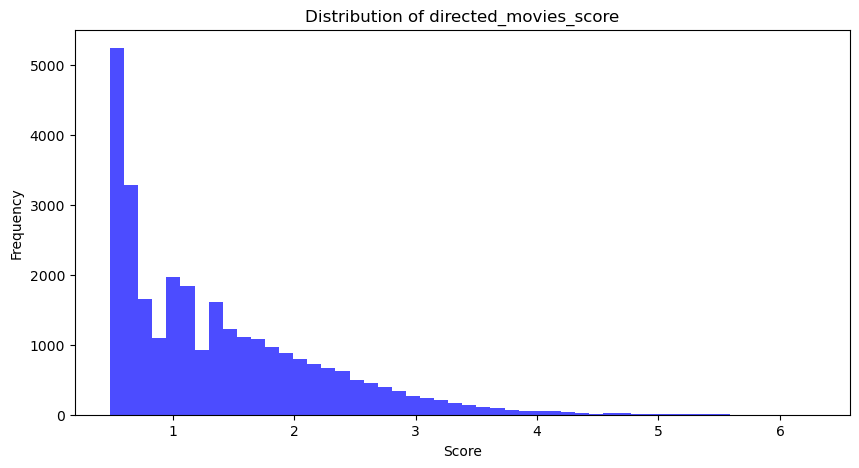

In [ ]:
movie_awards_success = movies_metric.loc[movies_metric['movie_awards_success'] > 0, 'movie_awards_success']

plt.figure(figsize=(10, 5))
plt.hist(movie_awards_success, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
movies_metric.sort_values(by='movie_awards_success', ascending=False)[:10]

,tconst,total_events,total_nominations,total_wins,movie_awards_success
3812,tt0056758,200,864,285,6.284766
4972,tt0065272,183,764,191,6.082668
4147,tt0058796,184,689,226,6.071536
26173,tt1392190,115,458,240,5.798228
26473,tt1454468,124,414,238,5.742738
24383,tt1065073,110,381,171,5.582454
14438,tt0167260,95,328,206,5.533885
26107,tt1375666,104,362,156,5.518911
27404,tt1655442,107,358,158,5.518878
25633,tt1285016,96,345,168,5.504304


We include these new scores into the movies dataframe,

In [ ]:
movies = pd.merge(movies,movies_metric, on='tconst').drop(columns=['total_events','total_nominations','total_wins'])

We include this metric in addition to the original metric (only using votes) that we had .

The exact formula to use is still something idk, the one below hasn't been thought through, it's just to include it for now

In [ ]:
def metric(row):
    return np.log10(row['votes']) * (row['rating']) + (row['movie_awards_success'] ** 1.5)
movies['score'] = movies.apply(metric, axis=1)

## Director's awards success

In [ ]:
dir_awards = awards[~awards['isTitle']]

In [ ]:
directors_awards = (pd.merge(dir_awards,directors['nconst'],left_on= 'const', right_on='nconst', how='inner')).drop('const',axis=1)

directors_awards['categoryName_lower'] = directors_awards['categoryName'].str.lower()
directors_awards['nomeneeNote_lower'] = directors_awards['nomeneeNote'].str.lower()

directors_awards['isPrimary'] = directors_awards['isPrimary'].astype(bool)
directors_awards['isSecondary'] = directors_awards['isSecondary'].astype(bool)

# Filter awards for directorial roles
directors_awards = directors_awards[
    (directors_awards['isPrimary'] | directors_awards['isSecondary']) & 
    ((directors_awards['categoryName_lower'].isna()) | (~directors_awards['categoryName_lower'].str.contains('actor|actress'))) & 
    ((directors_awards['nomeneeNote_lower'].isna()) | (~directors_awards['nomeneeNote_lower'].str.contains('actor|actress')))
]

# Drop the temporary lowercase columns
directors_awards = directors_awards.drop(['categoryName_lower', 'nomeneeNote_lower'], axis=1)

display(directors_awards)

,eventId,eventName,awardName,year,occurrence,winAnnouncementTime,categoryName,nomeneeNote,name,originalName,...,episodeNames,characterNames,isWinner,isPrimary,isSecondary,isPerson,isTitle,isCompany,notes,nconst
0,ev0000263,French Syndicate of Cinema Critics,Critics Award,1992,1,NaN,Best Film,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0729626
1,ev0000091,Berlin International Film Festival,Golden Berlin Bear,2007,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0729626
2,ev0000400,Locarno International Film Festival,Special Prize of the Jury,1974,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0729626
3,ev0001574,Gaudí Awards,Gaudí Award,2009,1,NaN,Best European Film (Millor Pel·lícula Europea),(director),Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,France/Italy,nm0729626
4,ev0000450,Moscow International Film Festival,Golden St. George,1995,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0729626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187216,ev0000091,Berlin International Film Festival,Golden Berlin Bear,1960,1,NaN,<NA>,<NA>,Ville Salminen,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0758744
187217,ev0000091,Berlin International Film Festival,Golden Berlin Bear,1960,1,NaN,<NA>,<NA>,Prabhat Mukherjee,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0611542
187218,ev0000091,Berlin International Film Festival,Silver Berlin Bear,1960,1,NaN,Special Prize - Short Film,<NA>,Juan Berend,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0073501
187219,ev0000409,AFI Fest,Documentary Award - Special Mention,2001,1,NaN,<NA>,<NA>,Jan Louter,<NA>,...,['A Sad Flower in the Sand (#8.7)'],<NA>,True,True,True,True,False,False,"For episode ""A Sad Flower in the Sand (#8.7)"".",nm1098324


We count number of nominations and wins,

In [ ]:
import pandas as pd

# Count total nominations (wins + losses) for each nconst
total_nominations = directors_awards.groupby('nconst').size().reset_index(name='total_nominations')

# Count number of wins for each nconst
wins_count = directors_awards[directors_awards['isWinner'] == 'True'].groupby('nconst').size().reset_index(name='wins_count')

# Merge the two counts based on 'nconst'
nominations_and_wins = pd.merge(total_nominations, wins_count, on='nconst', how='left').fillna(0)
nominations_and_wins['wins_count'] = nominations_and_wins['wins_count'].astype(int)
nominations_and_wins['total_nominations'] = nominations_and_wins['total_nominations'].astype(int)

display(nominations_and_wins)

,nconst,total_nominations,wins_count
0,nm0000005,130,76
1,nm0000008,15,8
2,nm0000009,13,8
3,nm0000018,40,27
4,nm0000019,114,65
...,...,...,...
16444,nm8956708,1,1
16445,nm9054338,2,1
16446,nm9335192,2,1
16447,nm9801575,1,0


In [ ]:
directors = pd.merge(directors,nominations_and_wins,on='nconst',how='left')
directors['total_nominations'].fillna(0, inplace=True)
directors['wins_count'].fillna(0, inplace=True)
directors['total_nominations'] = directors['total_nominations'].astype(int)
directors['wins_count'] = directors['wins_count'].astype(int)
display(directors)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,total_nominations,wins_count
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467",130,76
1,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646",15,8
2,nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0087803,tt0057877,tt0059749,tt0061184",13,8
3,nm0000018,Kirk Douglas,1916,2020,"actor,producer,soundtrack","tt0049456,tt0050825,tt0054331,tt0080736",40,27
4,nm0000019,Federico Fellini,1920,1993,"writer,director,actor","tt0050783,tt0053779,tt0056801,tt0071129",114,65
...,...,...,...,...,...,...,...,...
28493,nm9923550,Peder Pedersen,<NA>,<NA>,"director,miscellaneous,editor","tt1989553,tt1441426,tt0497368,tt1504682",0,0
28494,nm9928872,K.S. Raveendran,<NA>,<NA>,"writer,director",tt4507090,0,0
28495,nm9965211,Vasanth Balan,<NA>,<NA>,director,tt8685998,0,0
28496,nm9965267,Ramesh Khanna,<NA>,<NA>,director,tt0274959,0,0


In the same manner as before but for directors, trying to have a weighted sum of some sort + log at the end to smooth it out of those two elements. Haven't included the number of events here, i guess we could include it

In [ ]:
def awards_metric(row,max_nominations,max_wins):
    # Extract relevant data from the row
    total_nominations = row['total_nominations']
    wins_count = row['wins_count']

    normalized_nominations = total_nominations / max_nominations if max_nominations > 0 else 0
    normalized_wins = wins_count / max_wins if max_wins > 0 else 0

    weight_nominations = 0.3
    weight_wins = 0.7

    sw = (weight_nominations * normalized_nominations) + (weight_wins * normalized_wins)
    scaled_sw = np.log1p(sw * 100)

    return scaled_sw

max_nominations = directors['total_nominations'].max()
max_wins = directors['wins_count'].max()

directors['awards_success'] = directors.apply(
    lambda row: awards_metric(row, max_nominations, max_wins),
    axis=1
)

In [ ]:
directors.sort_values(by='awards_success', ascending=False)[:10][['nconst','primaryName','awards_success']]

,nconst,primaryName,awards_success
4444,nm0190859,Alfonso Cuarón,4.615121
81,nm0000229,Steven Spielberg,4.371868
78,nm0000217,Martin Scorsese,4.313302
84,nm0000233,Quentin Tarantino,4.303186
314,nm0001054,Joel Coen,4.233572
92,nm0000264,Pedro Almodóvar,4.207054
12833,nm0634240,Christopher Nolan,4.146630
26,nm0000095,Woody Allen,4.110234
313,nm0001053,Ethan Coen,4.069328
7866,nm0381116,Don Hertzfeldt,4.067701


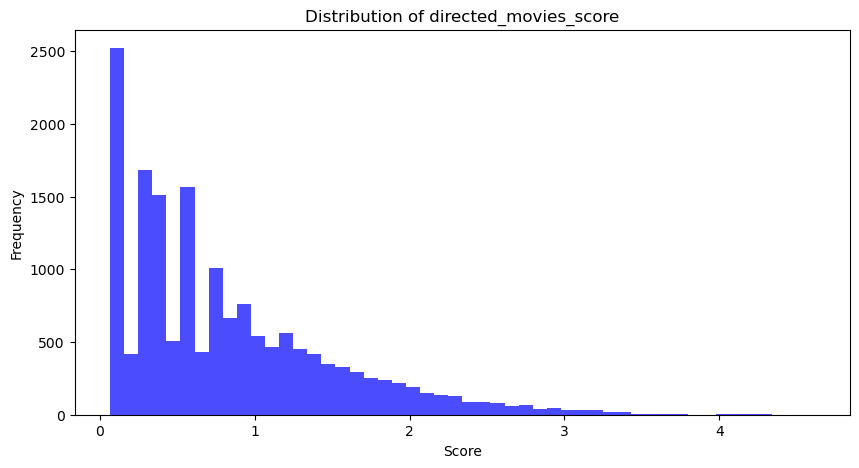

In [ ]:
valid_awards_success = directors.loc[directors['awards_success'] > 0, 'awards_success']

plt.figure(figsize=(10, 5))
plt.hist(valid_awards_success, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

A lot of directors with no nominations/prizes, but still an interesting metric to take into account. 

In the histogram above, i removed all 0 values, which leaves us with 16k directors with awards information.

Weights were taken completely arbitrarily, we can try others / a different type of weighted sum. I emphasized wins over nominations, but we can try differently.

In any case, the distribution is always going to be skewed with some directors rarely nominated/won. But, i think it's still a good metric : we have enough info, we just have to agree how we define it exactly.

### Director's movie success

In [ ]:
def directed_movies_metrics(director):
    directed_movies = movies[movies.directors.str.contains(director.nconst)]
    score = {
        'hits-0': ((directed_movies.score >= 0) & (directed_movies.score < 10)).sum(),
        'hits-10': ((directed_movies.score >= 10) & (directed_movies.score < 20)).sum(),
        'hits-20': ((directed_movies.score >= 20) & (directed_movies.score < 30)).sum(),
        'hits-30': ((directed_movies.score >= 30) & (directed_movies.score < 40)).sum(),
        'hits-40': ((directed_movies.score >= 40) & (directed_movies.score < 45)).sum(),
        'hits-45': ((directed_movies.score >= 45) & (directed_movies.score < 50)).sum(),
        'hits-50': (directed_movies.score >= 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

directors['score'] = directors.apply(directed_movies_metrics, axis=1)

C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()
C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()
C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behav

In [ ]:
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

directors.drop('score', axis=1, inplace=True)

Let's try to have another score besides the 'avg-3' one. 'avg-3' is good, the motivation here is to get a metric that could maybe apply to a larger number of directors.

The idea is to use the 'hits-{...}' columns to quantify the success of the director's directed movies, using the movie scores. Keeping in mind the Martin Scorcese example, we will try to weight the hits in order to 'weight up' the ones that were very successful. We do not care if a few movies were maybe not as successful : what really define bright directors is their hits. However, i still hope that if a director had many unsuccessful movies it will still rank them low.


$$ \text{Score}_{\text{directed\_movies\_final}} = \sqrt{\sum_{i} \left( \text{Weight}_i \times \log(\text{hits}_i + 1) \right)} $$

Where:
- $ i $ is the index of the 'hits-{...}' category.
- $ \text{Weight}_i $ is the weight assigned to the 'hits-{...}' category.
- $ \text{hits}_i $ is the value of the 'hits-{...}' category for the director.
- $ \max(\text{hits}_i) $ is the maximum value in the 'hits-{...}' category across all directors.



In [ ]:
weights = {
    'hits-0': 1,
    'hits-10': 2,
    'hits-20': 4,
    'hits-30': 6,
    'hits-40': 10,
    'hits-45': 14,
    'hits-50': 20,
}

for index, row in directors.iterrows():
    total_score = 0
    for column, weight in weights.items():
        hits_column = f'{column}'
        if not pd.isna(row[hits_column]):
            log_hits = np.log1p(row[hits_column])
            total_score += (log_hits) * weight

    directors.at[index, 'directed_movies_score'] = np.sqrt(total_score)

In [ ]:
directors.sort_values(by='directed_movies_score', ascending=False)[:15][['nconst','primaryName','awards_success','directed_movies_score','avg-3']]

,nconst,primaryName,awards_success,directed_movies_score,avg-3
81,nm0000229,Steven Spielberg,4.371868,10.570120,62.246815
78,nm0000217,Martin Scorsese,4.313302,9.488288,61.941705
6,nm0000033,Alfred Hitchcock,2.627856,9.407305,52.447394
47,nm0000142,Clint Eastwood,4.057330,9.309409,55.931179
314,nm0001054,Joel Coen,4.233572,9.082441,57.218259
198,nm0000631,Ridley Scott,3.112989,9.066648,57.582714
26,nm0000095,Woody Allen,4.110234,8.994958,49.454657
313,nm0001053,Ethan Coen,4.069328,8.908800,57.218259
109,nm0000318,Tim Burton,2.712534,8.858359,49.984643
58,nm0000165,Ron Howard,2.940282,8.744222,53.549559


In [ ]:
directors.sort_values(by='avg-3', ascending=False)[:15][['nconst','primaryName','awards_success','directed_movies_score','avg-3']]

,nconst,primaryName,awards_success,directed_movies_score,avg-3
12833,nm0634240,Christopher Nolan,4.146630,7.250859,68.313762
404,nm0001392,Peter Jackson,4.046675,7.559237,67.817948
84,nm0000233,Quentin Tarantino,4.303186,8.150945,64.69338
81,nm0000229,Steven Spielberg,4.371868,10.570120,62.246815
78,nm0000217,Martin Scorsese,4.313302,9.488288,61.941705
132,nm0000399,David Fincher,3.460522,7.352769,60.652904
113,nm0000338,Francis Ford Coppola,3.047580,8.544189,60.457885
37,nm0000116,James Cameron,3.389581,7.252727,59.736495
217,nm0000709,Robert Zemeckis,2.722743,8.559506,58.398955
17477,nm0881279,Lee Unkrich,2.582583,5.673514,57.814269


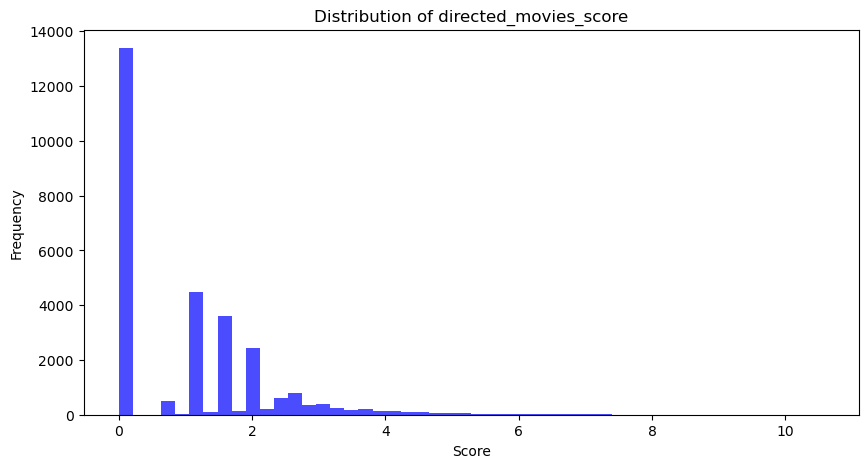

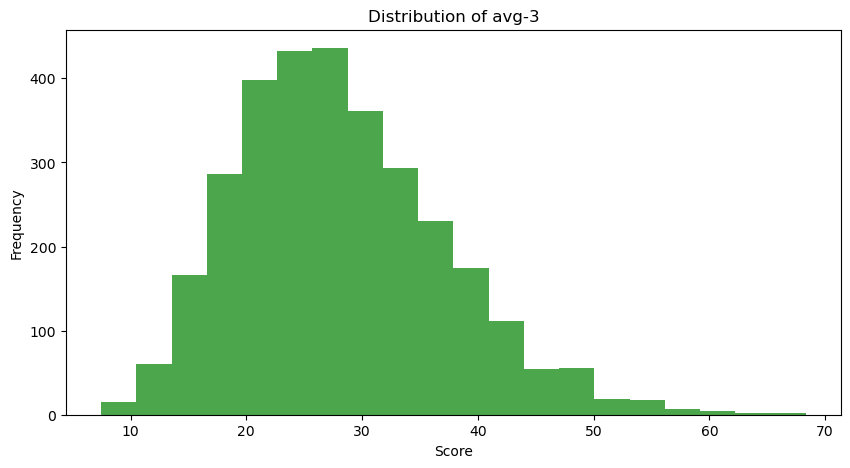

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(directors['directed_movies_score'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'avg-3'
plt.figure(figsize=(10, 5))
plt.hist(directors['avg-3'].dropna(), bins=20, color='green', alpha=0.7)
plt.title('Distribution of avg-3')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

--> Go for 'avg-3' as the main metric for 'movies directed success' of each director. The other metric is too heavily impacted by very successful directors with a lot of hit movies, i don't think it'll be good

In a sense, we loose a bit of info by only considering the three most successful movies for each director, but :

- As we said, one justification is saying that we only care about the best hits of each director, not the less succesful movies
of the directors

- We can also argue that by taking the director's awards information into account in another metric, this is where we take the 'entire career' of directors into account. For instance, if two directors have had their 3 most successful movies that are equally rated, but director 1 has had more success during his career, it is not unreasonable to think that they will have a higher awards score in the end. 


Idk if the awards metric is enough to differentiate directors that have a few hits with directors that spent their career being 'bright', but i still think we have to differentiate them a little in some way. Not necessarily hugely as it would skew the reparition, but still.

Maybe retry with a similar metric that I used here but differently ?

## left to do : how do we combine awards + movie success for directors into one metric ?